In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_spilt
from tensorflow.keras.preprocessing.sequence import pad_sequences

def load_data(file_path):
    tokenizer =Tokenizer(filters="")
    whole_texts=[]
    for line in open(file_path,encoding='utf-8'):
        #<s >< /s>←空白が必要
        whole_texts.append("<s> "+line.strip()+" </s>")
        
    tokenizer.fit_on_texts(whole_texts)
    
    return tokenizer.texts_to_sequences(whole_texts),tokenizer

x_train,tokenizer_en = load_data('data/train.en')
y_train,tokenizer_ja = load_data('data/train.ja')

en_vocab_size=len(tokenizer_en.word_index)+1
ja_vocab_size=len(tokenizer_ja.word_index)+1

x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,test_size=0.02,random_state=42)
x_train=pad_sequences(x_train,padding='post')
y_train=pad_sequences(y_train,padding='post')

seqX_len=len(x_train[0])
seqY_len=len(y_train[0])

ImportError: cannot import name 'train_test_spilt'

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.kayers import Input,Embedding,Dence,LSTM

emb_dim=256
hid_dim=256
##符号化器
#Inputレイヤー（返り値としてテンソルを受け取る）
encoder_inputs=Input(shape=(seqX_len,))#(seqX_len,)でseqX_lenという要素だけ持つTupleとなる

#モデルの層構成(手前の層の返り値テンソルを、次の接続したい層に別途引数として与える)
encoder_embedded=Embedding(en_vocab_size,emb_dim,mask_zero=True)(encoder_inputs)# shape: (seqX_len,)->(seqX_len, emb_dim)
# EmbeddingレイヤーとLSTMレイヤーを接続（+LSTMレイヤーのインスタンス化）
#*はunpacedある配列i=[1,2,3]をprint('i[1],i[2],i[3]')とできる(多分、zipと一緒に使ったよね)
_,*encoder_states=LSTM(hid_dim,return_state=True)(encoder_embedded)# shape: (seqX_len, emb_dim)->(hid_dim, )
# このLSTMレイヤーの出力に関しては下記に補足あり(output(h_t),state_h(隠れ状態),state_c(セル状態)=LSTM)


In [ ]:
##複合化器
#Inputレイヤー(返り値としてテンソルを受け取る)
decoder_inputs=Input(shape=(seqY_len))

#モデルの層構成(手前の層の返り値テンソルを、次の接続したい層に別途引数として与える)
decoder_embedding=Embedding(ja_vocab_size,emb_dim)
decoder_embedded=decoder_embedding(decoder_inputs)
#EmbeddingレイヤーとLSTMレイヤーを接続(encoder_statesを初期状態として指定)
decoder_lstm=LSTM(hid_dim,return_sequences=True,return_state=True)#あとで参照したいので、レイヤー自体を変数化
#(_は今回はoutputはいらないため受け取らない)
decoder_outputs,_,_=decoder_lstm(decoder_embedding,initial_state=encoder_states)#shape:(seqY_len,emb_dim)->(seqY_len,hid_dim)
#LSTMレイヤーとDenseレイヤーを接続
decoder_dense=Dense(ja_vocab_size,activation='softmax')
decoder_outputs=decoder_dense(decoder_outputs)

model=Model([encoder_inputs,decoder_inputs],decoder_outputs)
model.compilr(optimizer='rmsprop',loss='sparse_categorical_crossentropy')

In [ ]:
#サンプリング用（生成用）のモデルを作成

#符号化器(学習時と同じ構成、学習したレイヤーを利用)
encoder_model=Model(encoder_inputs,encoder_states)

#複合化器
decoder_states_inputs=[Input(shape=(hid_dim,)),Input(shape=(hid_dim,))]#decorder_lstmの初期状態指定用(h_t,c_t)


decoder_inputs=Input(shape=(1,))
decoder_embedded=decoder_embedding(decoder_imputs)#学習済みEmbeddingレイヤーを利用
decoder_outputs,*decoder_states=decoder_lstm(decoder_embedding,initial_state=decoder_states_inputs)#学習済みLSTMレイヤーを利用
decoder_outputs,*decoder_dense(decoder_outputs)#学習済みDenseレイヤーを利用

decoder_model=Model([decoder_input]+decoder_states_inputs,\
                    [decoder_out_puts]+decoder_states)

In [ ]:
def decode_sequence(input_seq,bos_eos,max_output_length=1000):
    states_value=encoder_model.predict(input_seq)
    
    target_seq=np.array(bos_eos[0])
    output_seq=bos_eos[0][:]
    
    while True:
        output_tokens,*states_value=decoder_model.predict([target_seq]+states_value)
        sampled_token_index=[np.argmax(output_tokens[0,-1,:])]
        output_seq+=sampled_token_index
        
        if(sampled_token_index == bos_eos[1] or len(output_seq)>max_output_length):
            break
            
        target_seq=np.array(sampled_token_index)
        
    return output_seq

In [ ]:
detokenizer_en=dict(map(reversed,tokenizer_en.word_index.items()))
detokenizer_ja=dict(map(reversed,tokenizer_ja.word_index.items()))

text_no=0
input_seq=pad_sequences([x_test[text_no]],seqX_len,padding="post")
bos_eos=tokenizer_ja.texts_to_sequences(["<s>","</s>"])

print('元の文',''.join([detokenizer_en[i] for i in x_test[text_no]]))
print('生成文',''.join([detokenizer_ja[i] for i in y_test[text_no]]))
print('正解文',''.join([detokenizer_ja[i] for i in y_test[test_no]]))


In [ ]:
detokenizer_en=dict(map(reversed,tokenizer_en.word_index.items()))
detokenizer_ja=dict(map(reversed,tokenizer_ja.word_index.items()))

text_no=0
input_seq=pad_sequences([x_test[text_no]],seqX_len,padding="post")
bos_eos=tokenizer_ja.texts_to_sequences(["<s>","</s>"])

print('元の文',''.join([detokenizer_en[i] for i in x_test[text_no]]))
print('生成文',''.join([detokenizer_ja[i] for i in y_test[text_no]]))
print('正解文',''.join([detokenizer_ja[i] for i in y_test[test_no]]))


In [ ]:
from nltk.translate.bleu_score import sentence_bleu,SmoothingFunction

prediction=['I','am','a','graduate','student','at','a','university']
reference=[['I','am','a','graduate','student','at','the','university','of','tokyo']]



In [ ]:
text_no =1
input_seq=pad_sequences([x_test[test_no]],seqX_len,padding='post')
bos_eos=tokenizer_ja.texts_to_sequences(["<s>","</s>"])

prediction=[detokenizer_ja[i] for i in decode_sequence(input_seq,bos_eos)]

reference=[[derokenizer_ja[i] for i in y_test[text_no]]]

print(prediction)
print(reference)

print(sentence_bleu(reference,prediction))

In [ ]:
'''ここからattention付き'''

In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

def load_data(file_path):#filepathでデータのダウンロード
    tokenizer=Tokenizer(filters="")
    whole_texts=[]
    for line in open(file_path,encoding='utf-8'):
        whole_texts.append("<s> "+line.strip()+" </s>")#文の始まりと終わりの指定
        
    tokenizer.fit_on_texts(whole_texts)#今回はバイナリベクトル表現化している
    
    return tokenizer.texts_to_sequences(whole_texts),tokenizer
#読み込みとtokenizerによる数値化
x_train,tokenizer_en=load_data('data/train.en')
y_train,tokenizer_ja=load_data('data/train.ja')

en_vocab_size=len(tokenizer_en.word_index)+1
ja_vocab_size=len(tokenizer_ja.word_index)+1

x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,test_size=0.02,random_state=42)

x_train=pad_sequences(x_train,padding='post')#各シーケンスの後をパディングする
y_train=pad_sequences(y_train,padding='post')

seqX_len=len(x_train[0])
seqY_len=len(y_train[0])


In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Permute,Activation,Embedding,Dense,LSTM,concatenate,dot
from tensorflow.keras import backend as K

emb_dim=256
hid_dim=256
att_dim=256

#符号化器
encoder_inputs = Input(shape=(seqX_len,))#英語文の一番長い文章の長さでshape
#mask_zeroはパディング部分を無視する
encoder_embedded=Embedding(en_vocab_size,emb_dim,mask_zero=True)(encoder_inputs)#単語ごとに入力

encoded_seq,*encoder_states=LSTM(hid_dim,return_sequences=True,return_state=True)(encoder_embedded)

#復号化器
decoder_inputs=Input(shape=(seqY_len,))#日本語の一番長い文でshape
decoder_embedding=Embedding(ja_vocab_size,emb_dim)#あとで参照するためにレイヤー自体の変数化を行う
decoder_embedded=decoder_embedding(decoder_inputs)
decoder_lstm=LSTM(hid_dim,return_sequences=True,return_state=True)
decoded_seq,_,_=decoder_lstm(decoder_embedded,initial_state=encoder_states)

#Attention
score_dense=Dense(hid_dim)#全結合層の変数化
score=score_dense(decoded_seq)#デコーダの隠れ層出力を全結合層へ

score=dot([score,encoded_seq],axes=(2,2))#エンコーダとの出力との類似度を内積でとる

attention=Activation('softmax')(score)#正規化

context=dot([attention,encoded_seq],axes=(2,1))#アテンションの値でエンコーダの値を重み付け

concat=concatenate([context,decoded_seq],axis=2)#アテンションとデコーダの連結(行で並べる)

attention_dense=Dense(att_dim,activation='tanh')#attentionの全結合層
attentional=attention_dense(concat)#concatをinput

output_dense=Dense(ja_vocab_size,activation='softmax')
outputs=output_dense(attentional)#outputはアテンションを適応したもの

model=Model([encoder_inputs,decoder_inputs],outputs)
model.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy')



In [3]:
import numpy as np

train_target=np.hstack((y_train[:,1:],np.zeros((len(y_train),1),dtype=np.int32)))

model.fit([x_train,y_train],np.expand_dims(train_target,-1),batch_size=128,epochs=10,verbose=2,validation_split=0.2)


/home/udoncat/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 39200 samples, validate on 9800 samples
Epoch 1/10
 - 26s - loss: 2.9412 - val_loss: 2.3713
Epoch 2/10
 - 24s - loss: 2.1379 - val_loss: 2.0467
Epoch 3/10
 - 24s - loss: 1.9104 - val_loss: 1.8904
Epoch 4/10
 - 24s - loss: 1.7688 - val_loss: 1.8026
Epoch 5/10
 - 24s - loss: 1.6553 - val_loss: 1.6781
Epoch 6/10
 - 24s - loss: 1.5542 - val_loss: 1.6319
Epoch 7/10
 - 24s - loss: 1.4598 - val_loss: 1.5375
Epoch 8/10
 - 24s - loss: 1.3679 - val_loss: 1.4805
Epoch 9/10
 - 24s - loss: 1.2803 - val_loss: 1.4076
Epoch 10/10
 - 24s - loss: 1.1997 - val_loss: 1.3556


In [4]:
#生成のフェイズ
#学習したエンコーダレイヤーを利用(encoder_inputやencoded_seq,encoder_states)
encoder_model=Model(encoder_inputs,[encoded_seq]+encoder_states)
#学習したエンコーダに合わせてimputの設定(バッチサイズhid_dim)
decoder_states_inputs=[Input(shape=(hid_dim,)),Input(shape=(hid_dim,))]
#デコーダのインプットは一次元
decoder_inputs=Input(shape=(1,))
#学習済みモデルで構築
decoder_embedded=decoder_embedding(decoder_inputs)
#学習済みモデルで構築(initialstateは内部状態の初期値(今回は(hid_dim,hid_dim)))
decoded_seq,*decoder_states=decoder_lstm(decoder_embedded,initial_state=decoder_states_inputs)
#inputが第一引数、アウトプットが第二引数
decoder_model=Model([decoder_inputs]+decoder_states_inputs,[decoded_seq]+decoder_states)
#バッチサイズseqX_len,inputdim=hid_dim
encoded_seq_in,decoded_seq_in=Input(shape=(seqX_len,hid_dim)),Input(shape=(1,hid_dim))
#学習済みdense層を用いる
score=score_dense(decoded_seq_in)
#以下学習済みattentionを用いる
score=dot([score,encoded_seq_in],axes=(2,2))
attention=Activation('softmax')(score)
context=dot([attention,encoded_seq_in],axes=(2,1))
concat=concatenate([context,decoded_seq_in],axis=2)
attentional=attention_dense(concat)
attention_outputs=output_dense(attentional)

attention_model=Model([encoded_seq_in,decoded_seq_in],[attention_outputs,attention])



In [7]:
def decode_sequence(input_seq,bos_eos,max_output_length=1000):
    #predictで予測できるinput_seqは与えるエンコーダの予測がencoded_seqに入り、
    #states_valueには時間ごとの(単語ごと)の隠れこみ層の値が入る
    encoded_seq,*states_value=encoder_model.predict(input_seq)
    print(bos_eos)
    target_seq=np.array(bos_eos[0])#bos_eos[0]="<s>"に対応するインデックス
    output_seq = bos_eos[0][:]#終わりは</s>
    #emptyでランダムな配列にできる
    attention_seq=np.empty((0,len(input_seq[0])))
    
    while True:
        #デコーダの予測値を格納
        decoded_seq,*states_value=decoder_model.predict([target_seq]+states_value)
        #アテンションの予測値を格納
        output_token,attention=attention_model.predict([encoded_seq,decoded_seq])
        #argmaxで今回追加したワードの中でもっとも数値が大きいものを選択(argmax内の処理は以下)
        '''
        import numpy as np
        a=np.array([[[2,3],[4,5]],[[6,7],[8,9]]])
        print(a[0,-1,:])
        output:[4 5]
        '''
        sampled_token_index=[np.argmax(output_token[0,-1,:])]
        #出力に値を追加する
        output_seq+=sampled_token_index
        #
        attention_seq=np.append(attention_seq,attention[0],axis=0)
        
        if(sampled_token_index == bos_eos[1] or len(output_seq)>max_output_length):
            break
        #
        target_seq=np.array(sampled_token_index)
        
    return output_seq,attention_seq

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
#逆順でソート
detokenizer_en=dict(map(reversed,tokenizer_en.word_index.items()))
detokenizer_ja=dict(map(reversed,tokenizer_ja.word_index.items()))
#一文目を予測している
text_no=0
#各シーケンスの後をパディングする(一番初めの要素を与える)
input_seq=pad_sequences([x_test[text_no]],seqX_len,padding='post')
print(input_seq)
#<s >< /s>←空白が必要
bos_eos=tokenizer_ja.texts_to_sequences(["<s>","</s>"])

output_seq,attention_seq=decode_sequence(input_seq,bos_eos)

print('元の文:', ' '.join([detokenizer_en[i] for i in x_test[text_no]]))
print('生成文:', ' '.join([detokenizer_ja[i] for i in output_seq]))
print('正解文:', ' '.join([detokenizer_ja[i] for i in y_test[text_no]]))

[[   1    7   93 2863   35  234   12  290    3    2    0    0    0    0
     0    0    0    0]]
[[1], [2]]
元の文: <s> you may extend your stay in tokyo . </s>
生成文: <s> 東京 に は お 茶 を 持 っ て い る 。 </s>
正解文: <s> 東京 滞在 を 延ば し て も い い で す よ 。 </s>


In [15]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
prediction = [detokenizer_ja[i] for i in output_seq]
reference = [[detokenizer_ja[i] for i in y_test[text_no]]]
print(sentence_bleu(reference, prediction))

ModuleNotFoundError: No module named 'nltk'

/home/udoncat/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 26481 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/udoncat/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 20140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/udoncat/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12395 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/udoncat/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12399 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/udoncat/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12362 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/udoncat/anacon

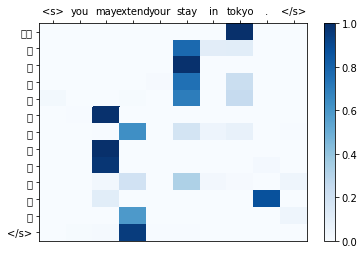

In [12]:
#Attentionの分布の描画
fig,ax=plt.subplots()
heatmap=ax.pcolor(attention_seq[:,:len(x_test[text_no])],cmap=plt.cm.Blues,vmax=1)
ax.set_xticks(np.arange(len(x_test[text_no]))+0.5,minor=False)
ax.set_yticks(np.arange(attention_seq.shape[0])+0.5,minor=False)
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.set_xticklabels([detokenizer_en[i] for i in x_test[text_no]],minor=False)
ax.set_yticklabels([detokenizer_ja[i] for i in output_seq[1:]],minor=False)
plt.colorbar(heatmap)
plt.show()

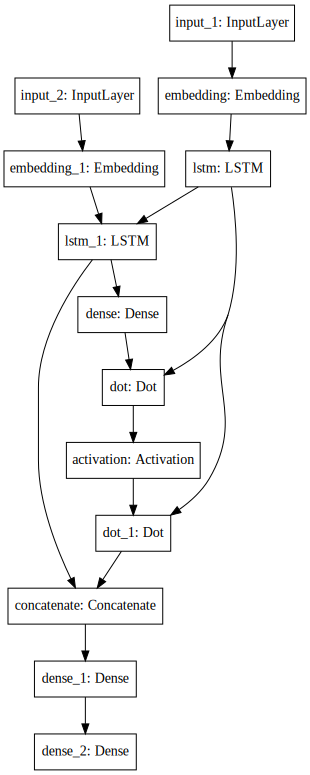

In [13]:
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot',format='svg'))